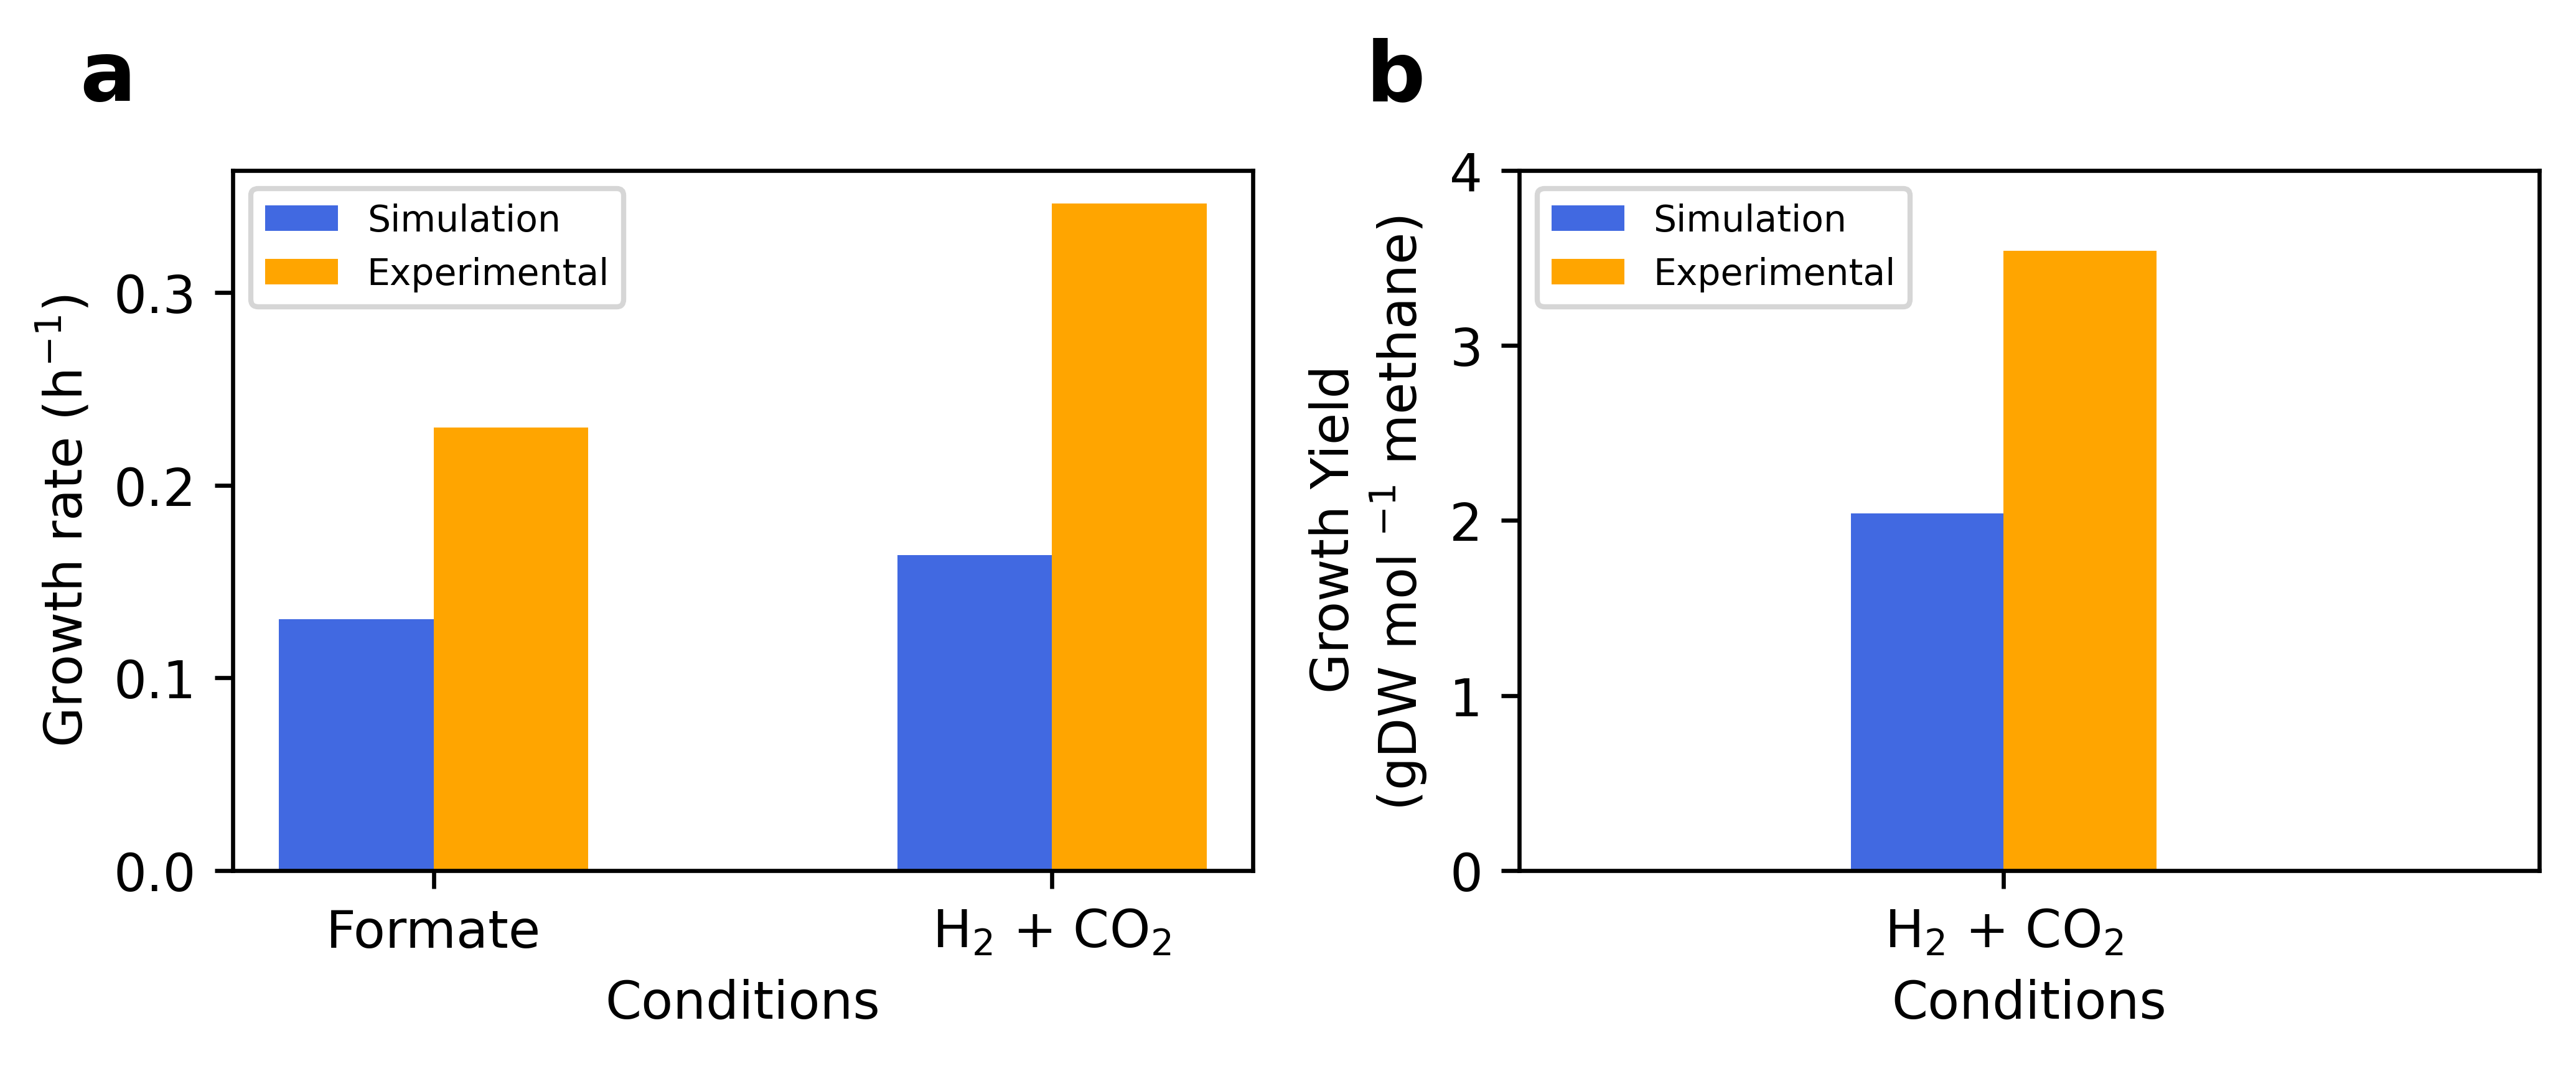

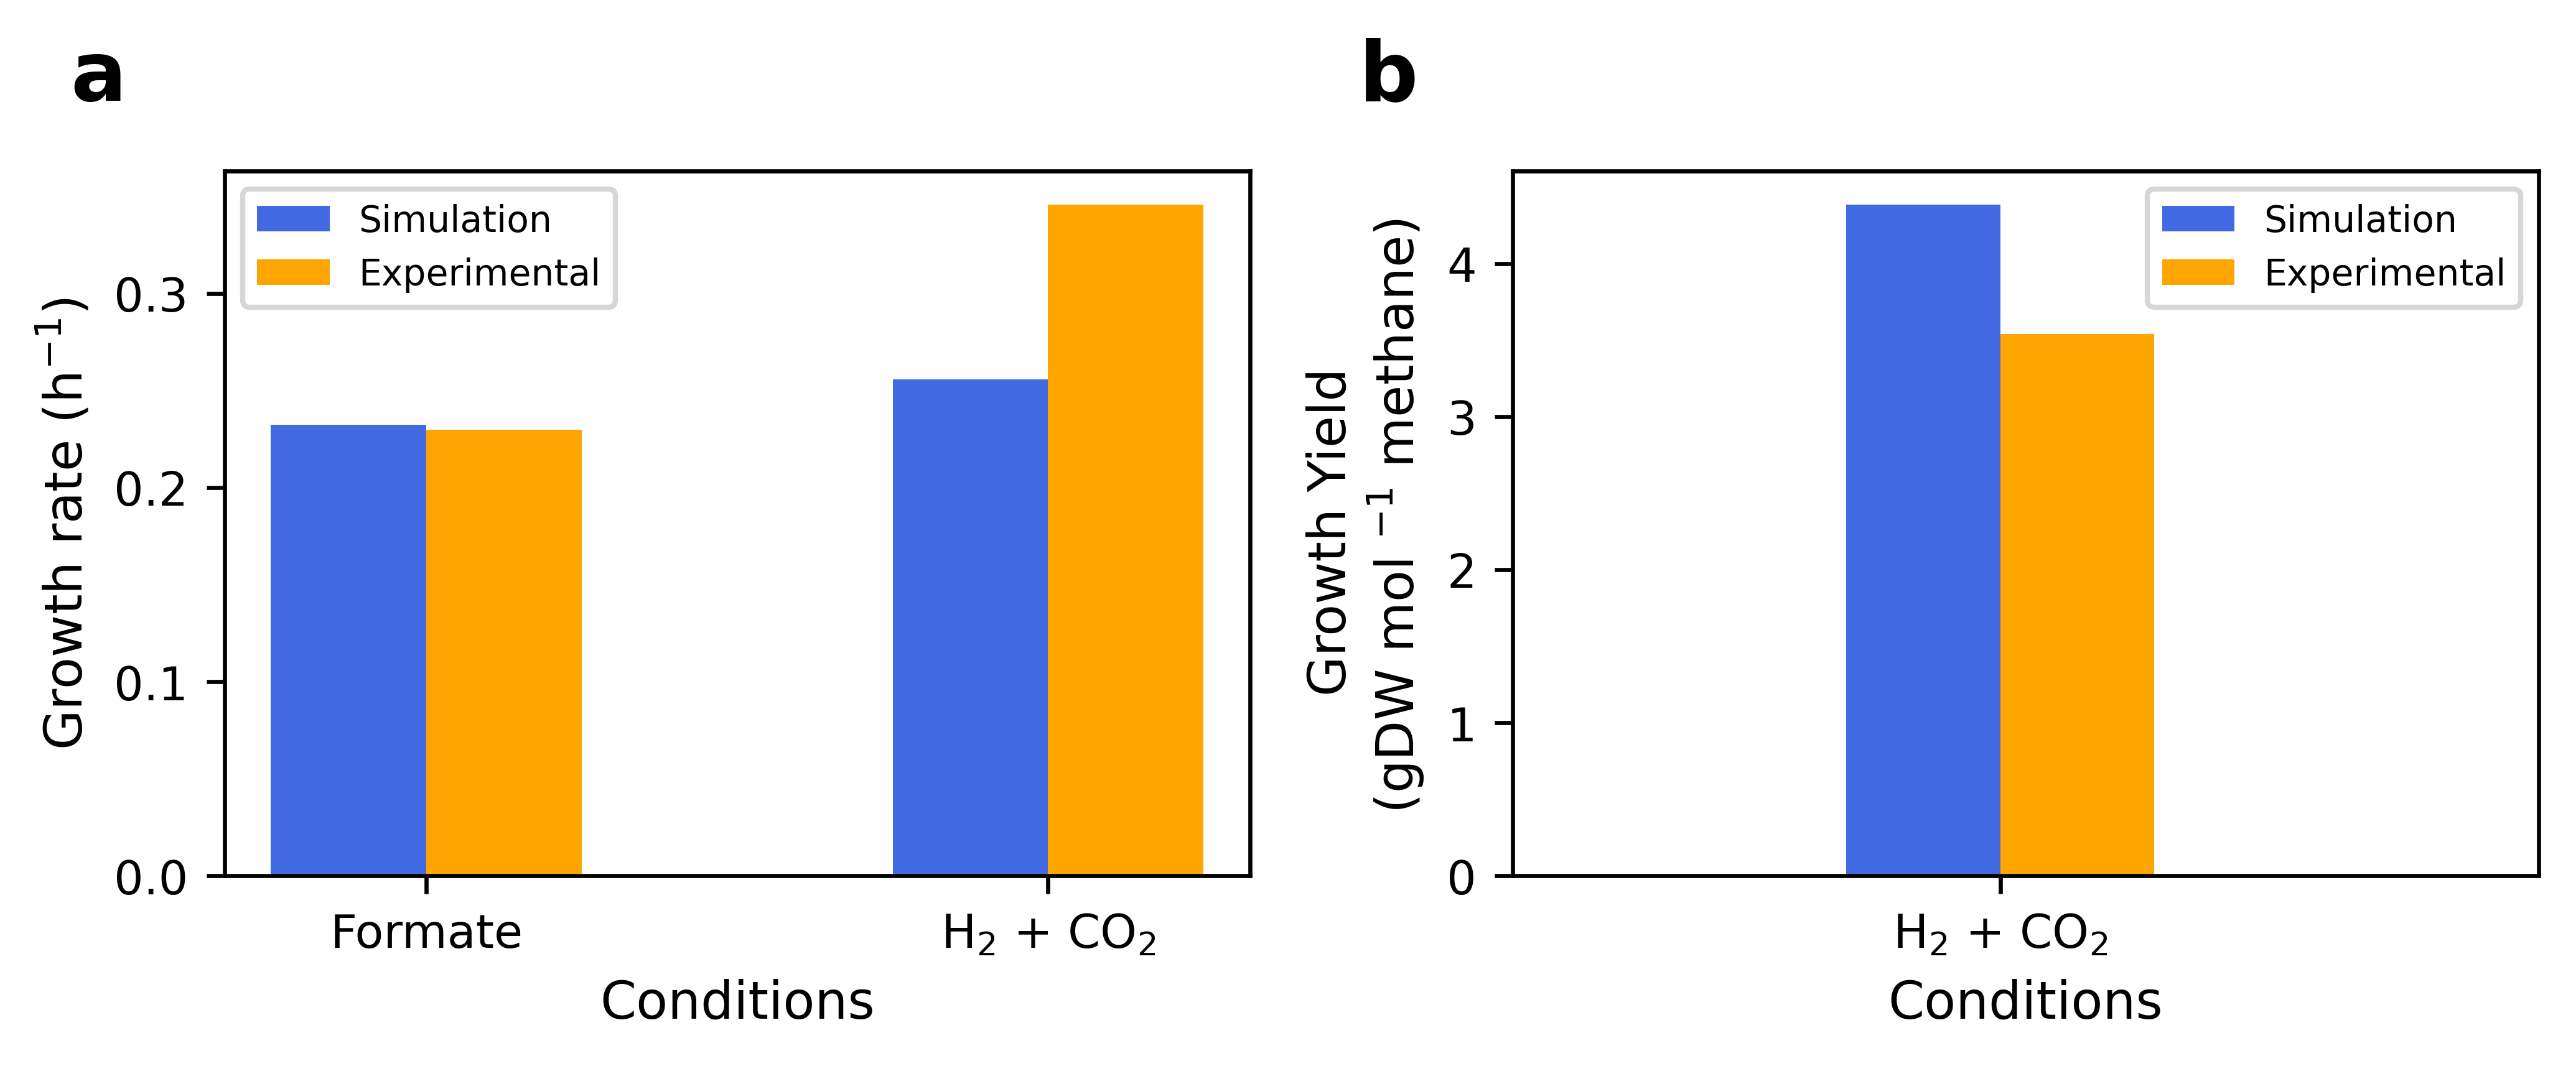

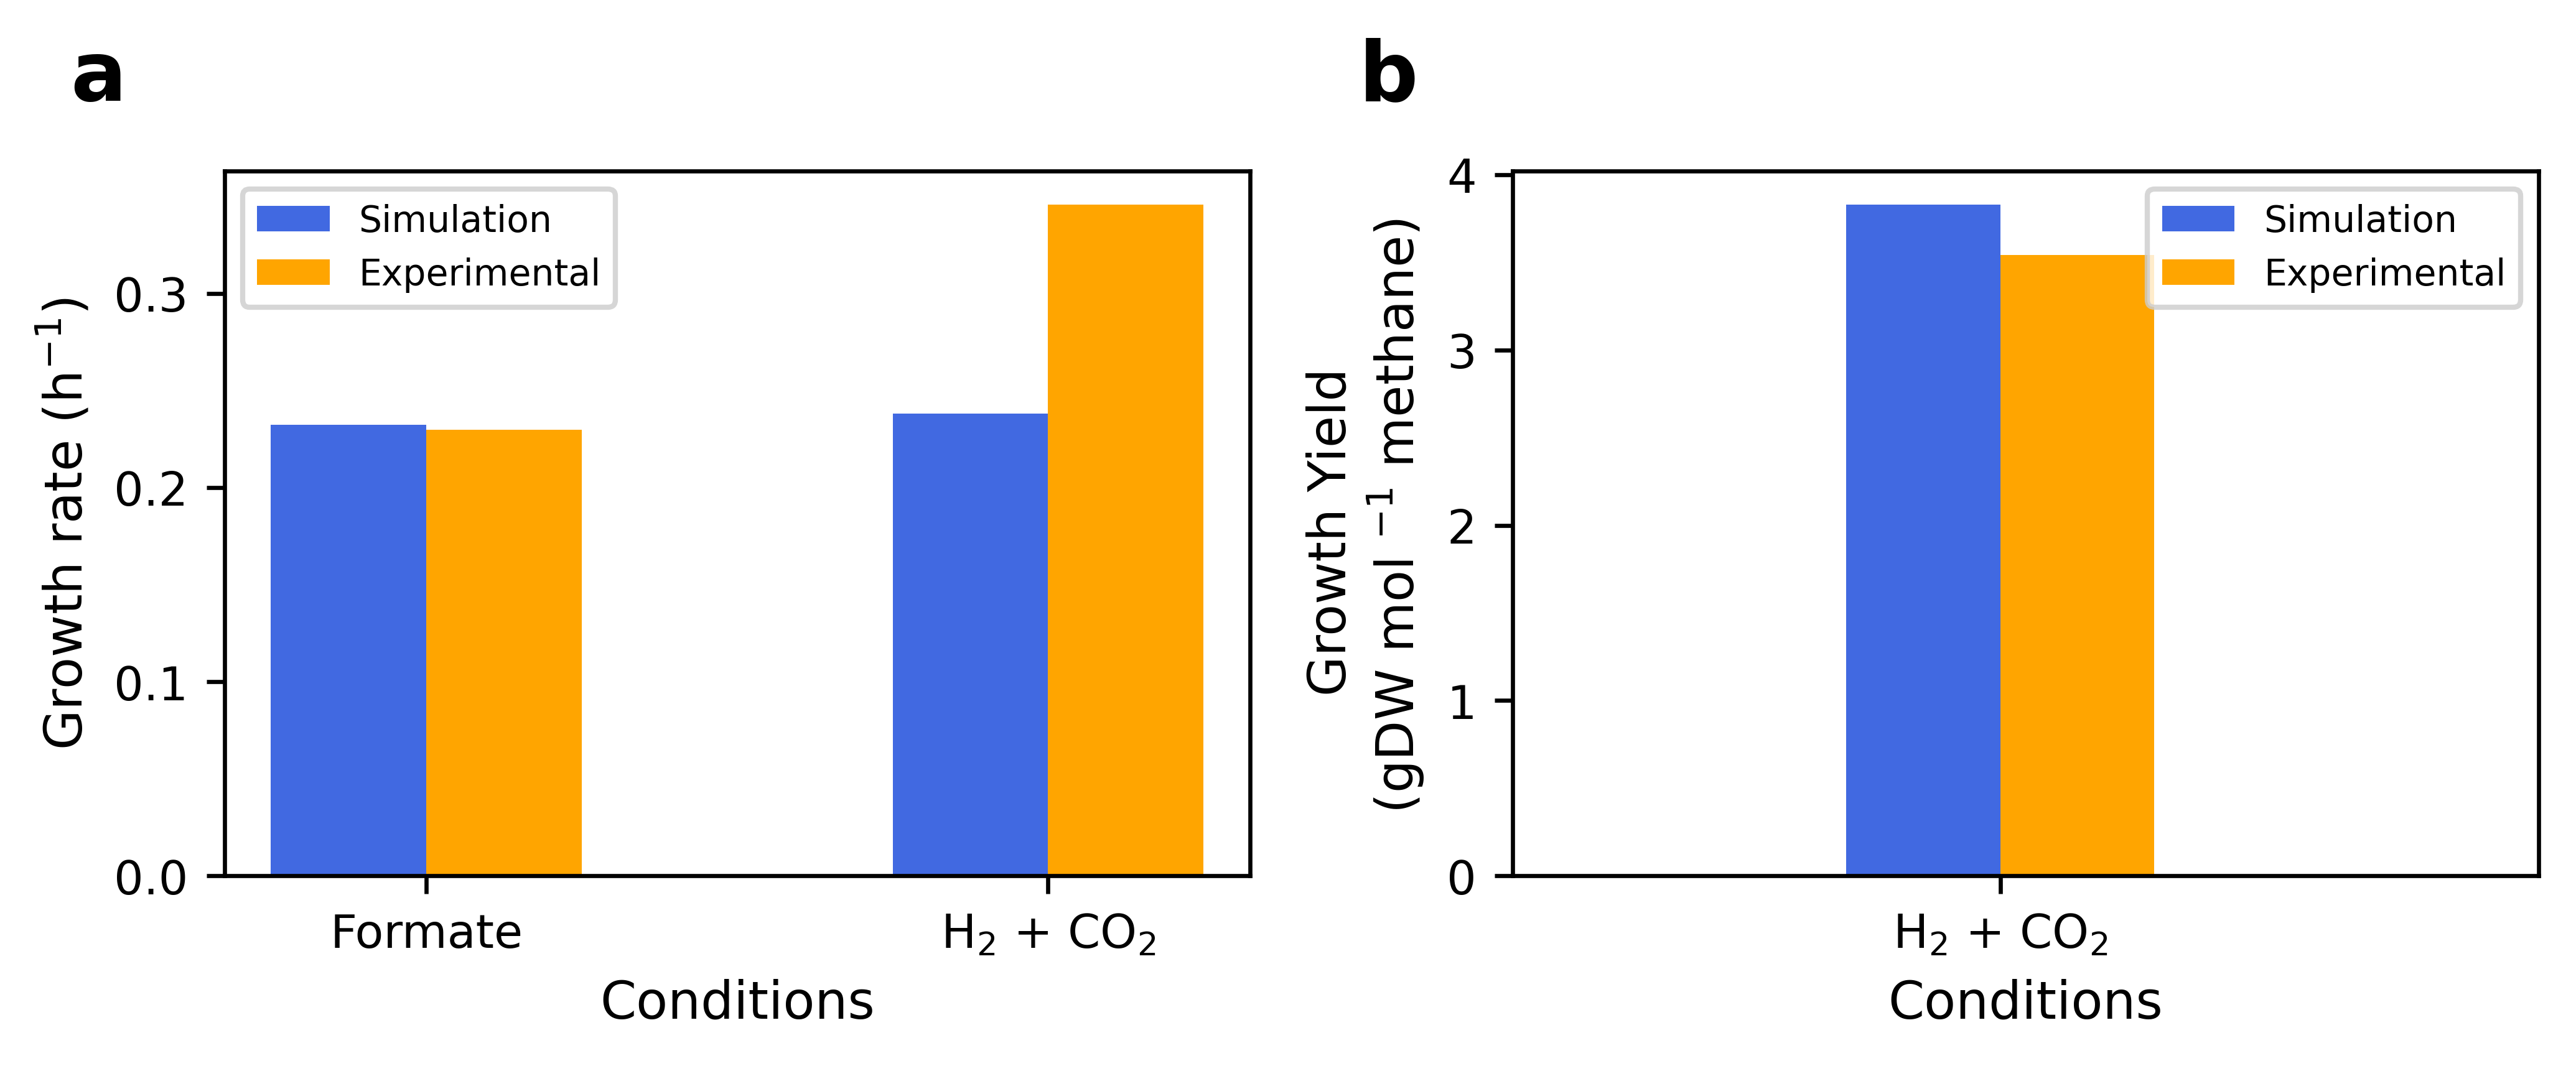

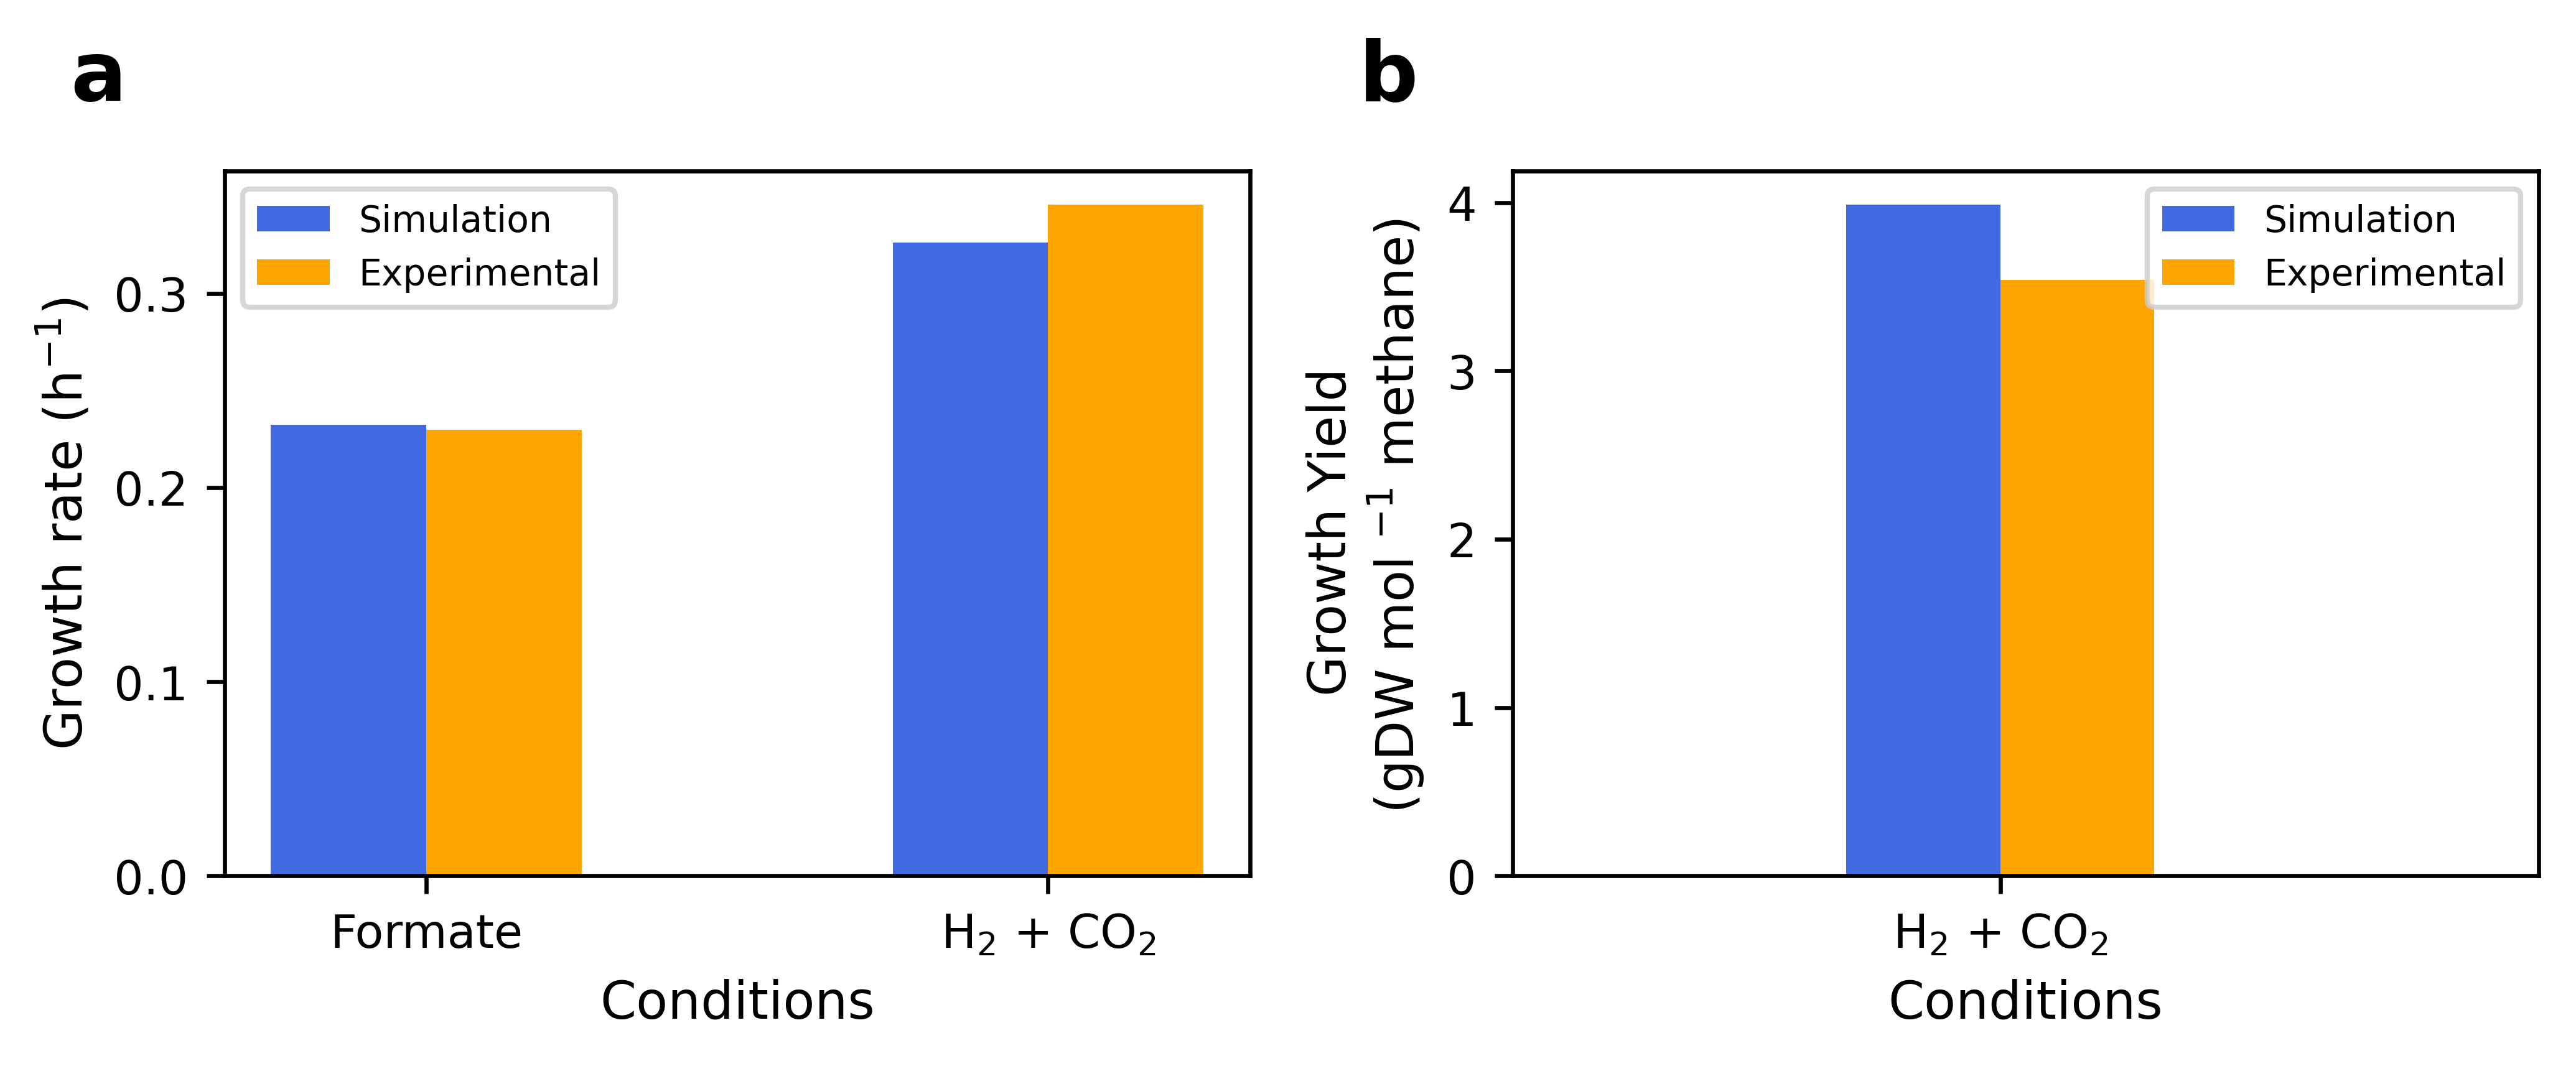

In [1]:
from simulation import Simulation
from extract_fluxes import Fluxes
import cobra
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def simulate_max_growth_conditions(UP_list, GAM_list, NGAM_list,x):
    
    conditions = {
        # closed import H2 ,CO2 ,CO,Acetate
       'Formate': ["R946","R913","R1165","R983"],
        # closed import Formate,CO
       'H2 + CO2': [ "R895", "R1165"]
    }
    results = {}
    # under condition of formate objective is formate
    #under condition CO2 + H2 objective is CO2
    objective=["R895","R913"]
   
    for i, (condition, closed_reactions) in enumerate(conditions.items()):
        
        simulation = Simulation()
        simulation.set_parameter(model_file='pcMMP.xml',GAM=GAM_list[i],NGAM=NGAM_list[i],objective=objective[i], file_path=f"output/lp_file_max_growth_{i}.lp",
                                         output_file=f"output/output_max_growth_{i}.lp",excel_file='pcMMP.xlsx')
        simulation.close_reactions(closed_reactions)
        UP=UP_list[i]
        simulation.set_constraint=[f"UP >= {UP}"] 
        growth = simulation.search_max_growth_rate(0,0.5)
        fluxes = Fluxes(simulation.model, f'output/output_max_growth_{i}.lp')
        if condition=="H2 + CO2":
            methan_flux=fluxes.extract_reaction_flux("R944")
            methan_yield=(growth*1000)/methan_flux
            
        results[condition] = growth
        
    plot_results(list(results.keys()), list(results.values()),methan_yield,x)
        
    
    return results,methan_yield

def plot_results(conditions, growth_rates, methane_yield,i):
    
    measured_growth = [0.23, 0.346]  
    bar_width_a = 0.25
    conditions_a = ["Formate",r"H$_2$ + CO$_2$"]
    index_a = np.arange(len(conditions_a))
    fig, axs = plt.subplots(1, 2, figsize=(7, 3), dpi=600) 
    plt.rcParams.update({
    "axes.titlesize": 12,
    "axes.labelsize": 10,
    "xtick.labelsize":9,
    "ytick.labelsize": 9,
    "legend.fontsize": 7
})

    axs[0].bar(index_a, growth_rates, bar_width_a, label='Simulation', color='royalblue')
    axs[0].bar(index_a + bar_width_a, measured_growth, bar_width_a, label='Experimental', color='orange')
    axs[0].set_ylabel('Growth rate (h$^{-1}$)')
    axs[0].text(-0.15, 1.1, 'a', transform=axs[0].transAxes, fontsize=16, fontweight='bold')
    axs[0].set_xticks(index_a + bar_width_a / 2)
    axs[0].set_xticklabels(conditions_a)
    axs[0].set_xlabel('Conditions')
    axs[0].set_yticks([0.0, 0.1, 0.2, 0.3])
    axs[0].legend()
    
    bar_width_b = 0.15
    conditions_b = ['H$_2$ + CO$_2$']
    index_b = np.arange(len(conditions_b))
    axs[1].bar(index_b, methane_yield, bar_width_b, label='Simulation', color='royalblue')
    axs[1].bar(index_b + bar_width_b, 3.54, bar_width_b, label='Experimental', color='orange')
    axs[1].set_ylabel('Growth Yield \n (gDW mol $^{-1}$ methane)')
    axs[1].set_xlabel('Conditions')
    axs[1].set_xticks(index_b + bar_width_b / 2)
    axs[1].set_xticklabels(conditions_b)
    axs[1].set_yticks([0,1, 2, 3, 4])
   
    axs[1].text(-0.15, 1.1, 'b', transform=axs[1].transAxes, fontsize=16, fontweight='bold')
    axs[1].legend()
    axs[1].set_xlim(-0.4, 0.6)

    plt.tight_layout()
    plt.savefig(f"Figures/max_growth_rate{i}.png", dpi=300)
    plt.show()
    
def run_simulations():

    conditions = [
       
        {"GAM": [25, 130], "NGAM": [1, 5], "UP": [0.75, 0.44]},
      
        {"GAM": [25, 25], "NGAM": [1, 1], "UP": [0.44, 0.44]},
       
        {"GAM": [25, 25], "NGAM": [1, 5], "UP": [0.44, 0.44]},
       
        {"GAM": [25, 25], "NGAM": [1, 5], "UP": [0.44, 0.2]}
    ]

    total_protein_mass = 0.6
    final_result = None
    final_methan_yield = None
    for i, c in enumerate(conditions):
        
        UP_list = [x * total_protein_mass for x in c["UP"]]
        final_result, final_methan_yield = simulate_max_growth_conditions(UP_list, c["GAM"], c["NGAM"],i)

if __name__ == "__main__":
    
    run_simulations()